From Phuc's notebook: Echo_images_diversity.ipynb

In [1]:
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import seaborn as sns

from collections import Counter
from diversity import Metacommunity
from itertools import combinations
from matplotlib import pyplot as plt, patches
from os import listdir
from os.path import expanduser
from scipy.stats import linregress
from sklearn.metrics import r2_score
from tqdm.notebook import tqdm

In [36]:
cmap = "bone_r"

### Data Wrangling

In [2]:
#Path to folder of ultrasound images
path = '/Volumes/Repo19/ArnaoutLab/Diversity_python_package_paper_2023/Imaging_dataset/5ID_test_240by240/'

In [3]:
outdir = expanduser("~") + "/ArnaoutLab Dropbox/Ramy Arnaout/Papers_2023/Diversity_python_package_paper_2023/"

In [5]:
#Create list of filenames of images (with non-png files filtered out):
image_list=[]

for filename in listdir(path):
    if filename[-3:] == 'png':
        image_list.append(filename)

In [6]:
set([i.split(".")[0].rsplit("_")[-1] for i in image_list])

{'3VT', '3VV', 'A4C', 'A5C', 'ABDO'}

In [7]:
#List first 10 images
image_list[:10]

['379481851_60_24_A4C.png',
 '425809275_67_1_A4C.png',
 '103464152_25_46_A4C.png',
 '307885319_17_15_A5C.png',
 '425809275_67_19_A4C.png',
 '086179587_74_5_3VV.png',
 '425809275_67_20_A4C.png',
 '379481851_60_48_A4C.png',
 '307885319_17_3_A5C.png',
 '379481851_60_53_A4C.png']

In [8]:
n = len(image_list)
n

137

In [9]:
image_list[-1]

'425809275_62_10_A4C.png'

In [10]:
#Removing the last image from image_list, so that there is an even number of images
image_list = image_list[:136]

In [11]:
n = len(image_list)
n

136

In [12]:
arr_list = []

for filename in image_list:
    arr_list.append(mpimg.imread(path + filename))
arr_list = np.array(arr_list)

In [13]:
arr_list.shape

(136, 240, 240)

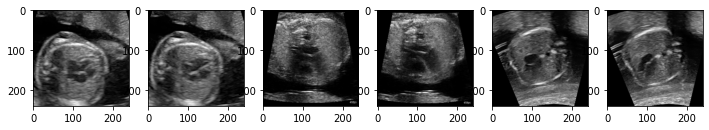

In [14]:
#Show a few pairs of images which are similar to each other according to the clustermap below
image_example =   arr_list[54]
image_example_2 = arr_list[31]
image_example_3 = arr_list[116]
image_example_4 = arr_list[65]
image_example_5 = arr_list[2]
image_example_6 = arr_list[68]
fig, axs = plt.subplots(ncols=6, figsize=(12,3))
axs[0].imshow(image_example,   cmap="gray")
axs[1].imshow(image_example_2, cmap="gray")
axs[2].imshow(image_example_3, cmap="gray")
axs[3].imshow(image_example_4, cmap="gray")
axs[4].imshow(image_example_5, cmap="gray")
axs[5].imshow(image_example_6, cmap="gray")
plt.show()

We indeed see that the first two images are very similar, and so on.

In [15]:
rmse = np.sqrt(np.mean((image_example - image_example_2)**2))
sim = np.exp(-rmse)
sim

0.9295771

In [16]:
#Listing the views of images

views = pd.Series([i.split(".")[0].rsplit("_")[-1] for i in image_list])

In [17]:
views

0      A4C
1      A4C
2      A4C
3      A5C
4      A4C
      ... 
131    A4C
132    A4C
133    A5C
134    3VV
135    A4C
Length: 136, dtype: object

In [18]:
class_balance = dict(Counter(views))

class_balance = {i: class_balance[i] for i in sorted(list(class_balance.keys()), reverse=True)}

class_balance

{'ABDO': 4, 'A5C': 35, 'A4C': 56, '3VV': 37, '3VT': 4}

In [19]:
#Computing the Shannon entropy of the class balance

def Shannon_ent(probs):
    Shannon_ent = 0
    for prob in probs:
        Shannon_ent += -prob*np.log(prob)
    return Shannon_ent

In [20]:
Shannon_ent([value/n for value in class_balance.values()])

1.2762490438971308

In [21]:
#1 image from each class

for view in class_balance.keys():
    for i in range(n):
        if views[i] == view:
            print((i, image_list[i]))
            break 

(37, '425809275_3_7_ABDO.png')
(3, '307885319_17_15_A5C.png')
(0, '379481851_60_24_A4C.png')
(5, '086179587_74_5_3VV.png')
(16, '086179587_74_2_3VT.png')


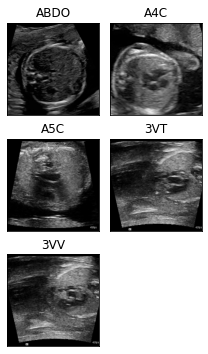

In [22]:
ix_view_pairs = (
    (37, "ABDO"),
    (0, "A4C"),
    (3, "A5C"),
    (16, "3VT"),
    (5, "3VV"),
)
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(3,5))
for ii, (ix, view) in enumerate(ix_view_pairs):
    i = ii//2
    j = ii % 2
    axs[i][j].imshow(arr_list[ix], cmap="gray")
    axs[i][j].set_title(view)
    axs[i][j].set_xticks([])
    axs[i][j].set_yticks([])
axs[2][1].set_xticks([])
axs[2][1].set_yticks([])
axs[2][1].axis("off")
plt.tight_layout()
plt.savefig(outdir + "medical_imaging_fig6a.pdf")
plt.show()

In [23]:
arr_list.shape

(136, 240, 240)

### First choice of similarity: RMSE

In [24]:
def rmse_similarity(img1, img2):
    rmse = np.sqrt(np.mean((img1 - img2)**2))
    sim = np.exp(-rmse)
    return sim

In [25]:
sim_array = np.zeros(shape=(n, n))
for i in tqdm(range(n)):
    for j in range(i, n):
        sim = rmse_similarity(arr_list[i], arr_list[j])
        sim_array[i][j] = sim
        sim_array[j][i] = sim

  0%|          | 0/136 [00:00<?, ?it/s]

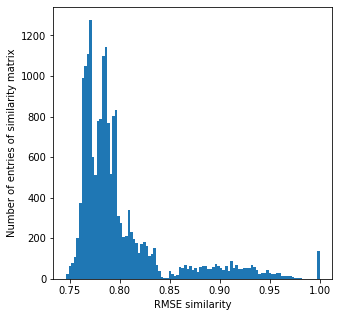

In [26]:
#Histogram of RMSE similarity 
plt.figure(figsize=(5,5))
plt.hist(sim_array.ravel(), bins = np.linspace(min(sim_array.ravel()),1,100))
plt.xlabel("RMSE similarity")
plt.ylabel("Number of entries of similarity matrix")
plt.show()

In [27]:
sim_array_rescaled = sim_array - sim_array.ravel().min()
sim_array_rescaled = sim_array_rescaled*(1/sim_array_rescaled.max())

In [28]:
lut = {"ABDO": "black", 
       "A4C": "#444", 
       "A5C": "#888", 
       "3VT": "#ccc", 
       "3VV": "white"
      }

In [29]:
sim_array_rescaled.shape

(136, 136)

/Users/ramy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/fastcluster.py:26: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.
  from numpy import double, empty, array, ndarray, var, cov, dot, bool, \
/Users/ramy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/ramy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/fastcluster.py:26: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.
  from numpy import double, empty, array, ndarray, var, cov, dot, bool, \
/Users/ramy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performanc

<Figure size 432x288 with 0 Axes>

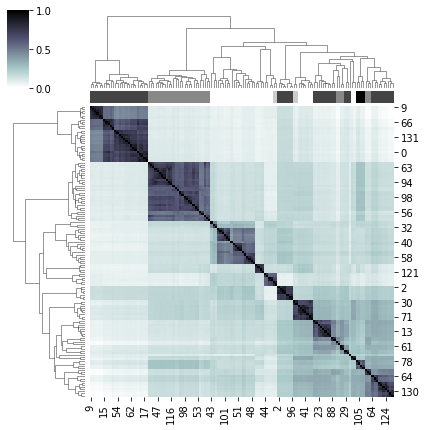

In [35]:
figsize = (6, 6)
edge_color = "white"
lw = 2
ls = ":"

rects = (
#     (( 0,  0), 26, 26),
#     ((26, 26), 28, 28),
#     ((54, 54), 20, 20),
#     ((74, 74), 10, 10),
#     ((84, 84), 52, 52),
)

plt.figure()
p = sns.clustermap(sim_array_rescaled, 
                   cmap=cmap, 
                   col_colors=views.map(lut).to_numpy(),
                   figsize=figsize)
for rect in rects:
    p.ax_heatmap.add_patch(patches.Rectangle(*rect, edgecolor=edge_color, facecolor='none', lw=lw, ls=ls))
# p.ax_heatmap.set_xticks([])
# p.ax_heatmap.set_yticks([])
p.ax_heatmap.grid(False)
plt.savefig(outdir + "medical_imaging_fig6b.pdf")
plt.show()

## Split \#1: Subset A vs. Subset B

<Figure size 432x288 with 0 Axes>

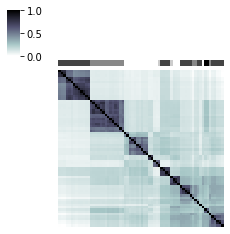

<Figure size 432x288 with 0 Axes>

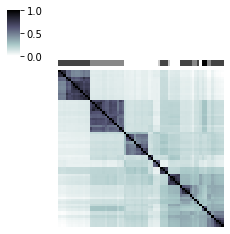

In [37]:
clustered_list = p.dendrogram_row.reordered_ind
odds  = clustered_list[0:None:2]
evens = clustered_list[1:None:2]
odds_colors  = views[odds].map(lut).to_numpy()
evens_colors = views[evens].map(lut).to_numpy()
simarray_odds  = sim_array_rescaled[odds, :][:, odds]
simarray_evens = sim_array_rescaled[evens, :][:, evens]

# Clustermap for subcommunities A and B---note: do not actually cluster!

# A
figsize=(3.5, 3.5)
plt.figure()
r1 = sns.clustermap(simarray_odds,  cmap=cmap, row_cluster=False, col_cluster=False, 
                    col_colors=odds_colors,  figsize=figsize, vmin=0, vmax=1)
r1.ax_heatmap.set_xticks([])
r1.ax_heatmap.set_yticks([])
r1.ax_heatmap.grid(False)
plt.savefig(outdir + "medical_imaging_fig7a.pdf")
plt.show()

# B
figsize=(3.5, 3.5)
plt.figure()
r2 = sns.clustermap(simarray_evens, cmap=cmap, row_cluster=False, col_cluster=False, 
                    col_colors=evens_colors, figsize=figsize, vmin=0, vmax=1)
r2.ax_heatmap.set_xticks([])
r2.ax_heatmap.set_yticks([])
r2.ax_heatmap.grid(False)
plt.savefig(outdir + "medical_imaging_fig7b.pdf")
plt.show()

In [32]:
# Count the number of views in each subcommunity

viewcounts_A = Counter(views[odds])
viewcounts_B = Counter(views[evens])
print("odds (A):",  viewcounts_A.most_common())
print("evens (B):", viewcounts_B.most_common())

Shannon_ent([value/len(odds)  for value in viewcounts_A.values()]), Shannon_ent([value/len(evens) for value in viewcounts_B.values()])

odds (A): [('A4C', 29), ('3VV', 18), ('A5C', 17), ('3VT', 2), ('ABDO', 2)]
evens (B): [('A4C', 27), ('3VV', 19), ('A5C', 18), ('3VT', 2), ('ABDO', 2)]


(1.2692799657211924, 1.2822839353136066)

In [33]:
# Compute R-squared
r_squared_partition_1 = linregress(list(viewcounts_A.values()), list(viewcounts_B.values())).rvalue**2
r_squared_partition_1

0.9899129840434799

In [43]:
#Create a dataframe to store the frequency of each image in each subcommunity.
#Because each image is unique, all frequencies are either 1 or 0.

counts_1 = pd.DataFrame(
    {
      "Odd-numbered":  [ clustered_list.index(i)      % 2 for i in range(n)],
      "Even-numbered": [(clustered_list.index(i) + 1) % 2 for i in range(n)]
    }
)

In [44]:
# Create a metacommunity object from the count dataframe and the similarity matrix above
metacommunity = Metacommunity(counts_1, similarity=sim_array_rescaled)

#Print out the diversity at viewpoint parameter q=0
df_1 = metacommunity.to_dataframe(viewpoint=[0, 1, np.inf])
df_1_reduced = df_1[['rho', 'normalized_rho', 'beta', 'normalized_beta']].iloc[1:3,:].T
df_1_reduced.loc['rho_hat'] = df_1_reduced.loc['rho'] - 1
df_1_reduced.loc['beta_hat'] = df_1_reduced.loc['beta']*2 - 1
df_1_reduced.columns = ['Subcommunity A', 'Subcommunity B']
df_1_reduced

,Subcommunity A,Subcommunity B
rho,1.979323,1.990544
normalized_rho,0.989662,0.995272
beta,0.505223,0.502375
normalized_beta,1.010446,1.004750
rho_hat,0.979323,0.990544
beta_hat,0.010446,0.004750


In [45]:
# view
df_1

,community,viewpoint,alpha,rho,beta,gamma,normalized_alpha,normalized_rho,normalized_beta
0,metacommunity,0.0,9.572304,1.984934,0.503799,4.823470,4.786152,0.992467,1.007598
1,Odd-numbered,0.0,9.506126,1.979323,0.505223,4.802801,4.753063,0.989662,1.010446
2,Even-numbered,0.0,9.638483,1.990544,0.502375,4.844138,4.819241,0.995272,1.004750
3,metacommunity,1.0,9.459827,1.984834,0.503820,4.766054,4.729913,0.992417,1.007641
4,Odd-numbered,1.0,9.398729,1.979228,0.505248,4.748684,4.699365,0.989614,1.010495
5,Even-numbered,1.0,9.521321,1.990456,0.502397,4.783487,4.760661,0.995228,1.004795
6,metacommunity,inf,7.867740,1.932922,0.514865,3.965851,3.933870,0.966461,1.029731
7,Odd-numbered,inf,7.867740,1.942255,0.514865,3.965851,3.933870,0.971128,1.029731
8,Even-numbered,inf,7.870071,1.932922,0.517351,3.967255,3.935035,0.966461,1.034703


We see that the $\rho$ index is approximately 2 for both subcommunities (and for any value of the viewpoint parameter). This index is called the redundancy in Reeves, so it makes sense that it is equal to 2 because there are 2 essentially identical subcommunities in this case. This can also be seen from equations as follows:

First, we recall the definition of $\rho$:

$$
{}^{q} \rho^{Z}_{j} = M_{1-q} \left( \bar{P}_{\cdot j} ; \frac{Zp}{Z P_{\cdot j}} \right) 
$$

For $q=0$ for example, this simplifies to

$$
\rho^{Z}_{j} = \sum_{i \in \mathrm{supp}{(\bar{P}_{\cdot j})}} (\bar{P}_{\cdot j})_{i} \frac{(Zp)_{i}}{(ZP_{\cdot j})_{i}}
$$

where $\bar{P}_{\cdot j}$ is defined to be $\frac{P_{\cdot j}}{w_j}$, and the weight $w_j$ is defined to be $\sum_{i} P_{ij}$. If we substitute back into the equation above, and ignore the effect of the similarity matrix by setting it to something close to the identity matrix, then we have

$$
\rho^{Z}_{j} \approx \sum_{i} \frac{\sum_{j} P_{ij}}{\sum_{i} P_{ij}}
$$

Now, because the two communities are very similar, all the nonzero $P_{ij}$ are equal to each other. So we see that the expression above simplifies to the number of subcommunities, which is $2$ in this case.

## Split \#2: Subset C vs. Subset D

Next, we repeat for a different way to partition the metacommunity. 

In [46]:
# List the original indices (as in image_list) of images belonging to subcommunity I
subcomm_C_indices = (clustered_list[:26] + clustered_list[114:117]) + (clustered_list[37:54]) + ([clustered_list[54]] + clustered_list[57:74]) + \
clustered_list[82:84] + clustered_list[119:121]

In [47]:
#Listing the original indices (as in image_list) of images belonging to subcommunity II
subcomm_D_indices = [i for i in range(n) if i not in subcomm_C_indices]

In [48]:
subcomm_C_views = list(views[subcomm_C_indices])

In [49]:
subcomm_D_views = views[subcomm_D_indices]

In [50]:
# Count the number of views in each subcommunity and store the results in a sorted dictionary

viewcounts_C = dict(Counter(subcomm_C_views))
viewcounts_D = dict(Counter(subcomm_D_views))

viewcounts_C = {i: viewcounts_C[i] for i in sorted(list(viewcounts_C.keys()), reverse=True)}
viewcounts_D = {i: viewcounts_D[i] for i in sorted(list(viewcounts_D.keys()), reverse=True)}

In [51]:
viewcounts_C

{'ABDO': 2, 'A5C': 17, 'A4C': 29, '3VV': 18, '3VT': 2}

In [52]:
viewcounts_D

{'ABDO': 2, 'A5C': 18, 'A4C': 27, '3VV': 19, '3VT': 2}

In [53]:
r_squared_partition_2 = linregress(list(viewcounts_C.values()), list(viewcounts_D.values())).rvalue**2
r_squared_partition_2

0.9899129840434799

In [54]:
def subcomm_C_check(i):
    if i in subcomm_C_indices:
        return 1
    else:
        return 0

counts_2 = pd.DataFrame(
    {
      "Subcommunity C": [subcomm_C_check(i) for i in range(len(image_list))],
    }
)

counts_2['Subcommunity D'] = (counts_2['Subcommunity C'] + 1) % 2

In [55]:
counts_2

,Subcommunity C,Subcommunity D
0,1,0
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
131,1,0
132,0,1
133,0,1
134,0,1


In [56]:
subcomm_C = list(filter(lambda filename: counts_2.loc[image_list.index(filename),'Subcommunity C'] ,image_list))
subcomm_D = list(filter(lambda filename: counts_2.loc[image_list.index(filename),'Subcommunity D'] ,image_list))

n_C = len(subcomm_C)
n_D = len(subcomm_D)

arr_list_C = list(map(lambda filename: mpimg.imread(path + filename), subcomm_C))
arr_list_D = list(map(lambda filename: mpimg.imread(path + filename), subcomm_D))

In [57]:
sim_array_C = np.zeros(shape=(n_C, n_C))
for i in tqdm(range(n_C)):
    for j in range(i, n_C):
        sim = rmse_similarity(arr_list_C[i], arr_list_C[j])
        sim_array_C[i][j] = sim
        sim_array_C[j][i] = sim

sim_array_D = np.zeros(shape=(n_D, n_D))
for i in tqdm(range(n_D)):
    for j in range(i, n_D):
        sim = rmse_similarity(arr_list_D[i], arr_list_D[j])
        sim_array_D[i][j] = sim
        sim_array_D[j][i] = sim

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

In [58]:
views_C = pd.Series([views[image_list.index(subcomm_C[i])] for i in range(n_C)])
views_D = pd.Series([views[image_list.index(subcomm_D[i])] for i in range(n_D)])

In [59]:
dict(Counter(views_C)).values()

dict_values([29, 17, 2, 18, 2])

In [60]:
Shannon_ent([value/n_C for value in dict(Counter(views_C)).values()])

1.2692799657211924

In [61]:
Shannon_ent([value/n_D for value in dict(Counter(views_D)).values()])

1.2822839353136066

/Users/ramy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/fastcluster.py:26: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.
  from numpy import double, empty, array, ndarray, var, cov, dot, bool, \
/Users/ramy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/fastcluster.py:26: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.
  from numpy import double, empty, array, ndarray, var, cov, dot, bool, \


<Figure size 432x288 with 0 Axes>

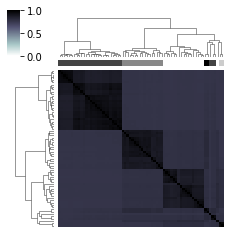

/Users/ramy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/fastcluster.py:26: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.
  from numpy import double, empty, array, ndarray, var, cov, dot, bool, \
/Users/ramy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/fastcluster.py:26: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.
  from numpy import double, empty, array, ndarray, var, cov, dot, bool, \


<Figure size 432x288 with 0 Axes>

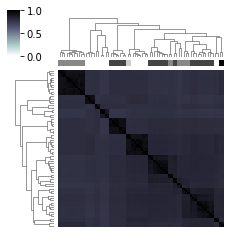

In [62]:
# Clustermaps for subcommunities C and D

figsize=(3.5, 3.5)

# C
plt.figure()
q1 = sns.clustermap(sim_array_C, cmap=cmap, col_colors = views_C.map(lut).to_numpy(), figsize=figsize, 
                    vmin=0, vmax=1)
q1.ax_heatmap.set_xticks([])
q1.ax_heatmap.set_yticks([])
q1.ax_heatmap.grid(False)
plt.savefig(outdir + "medical_imaging_fig7c.pdf")
plt.show()

# D
plt.figure()
q2 = sns.clustermap(sim_array_D, cmap=cmap, col_colors = views_D.map(lut).to_numpy(), figsize=figsize, 
                    vmin=0, vmax=1)
q2.ax_heatmap.set_xticks([])
q2.ax_heatmap.set_yticks([])
q2.ax_heatmap.grid(False)
plt.savefig(outdir + "medical_imaging_fig7d.pdf")
plt.show()

In [63]:
#Creating the metacommunity object 
metacommunity_2 = Metacommunity(counts_2, similarity=sim_array_rescaled)

In [64]:
#Print out the diversity at q=0
df_2 = metacommunity_2.to_dataframe(viewpoint=[0, 1, np.inf])
df_2_reduced = df_2[['rho', 'normalized_rho', 'beta', 'normalized_beta']].iloc[1:3,:].T
df_2_reduced.loc['rho_hat'] = df_2_reduced.loc['rho'] - 1
df_2_reduced.loc['beta_hat'] = df_2_reduced.loc['beta']*2 - 1
df_2_reduced.columns = ['Subcommunity C', 'Subcommunity D']
df_2_reduced

,Subcommunity C,Subcommunity D
rho,1.695947,1.613562
normalized_rho,0.847974,0.806781
beta,0.589641,0.619747
normalized_beta,1.179282,1.239493
rho_hat,0.695947,0.613562
beta_hat,0.179282,0.239493


In [65]:
#Full diversity dataset

df_2

,community,viewpoint,alpha,rho,beta,gamma,normalized_alpha,normalized_rho,normalized_beta
0,metacommunity,0.0,7.966257,1.654755,0.604694,4.823470,3.983129,0.827377,1.209388
1,Subcommunity C,0.0,8.265377,1.695947,0.589641,4.899727,4.132689,0.847974,1.179282
2,Subcommunity D,0.0,7.667137,1.613562,0.619747,4.747212,3.833569,0.806781,1.239493
3,metacommunity,1.0,7.760777,1.628344,0.614121,4.766054,3.880388,0.814172,1.228241
4,Subcommunity C,1.0,8.042832,1.655894,0.603903,4.857094,4.021416,0.827947,1.207807
5,Subcommunity D,1.0,7.488613,1.601253,0.624511,4.676720,3.744307,0.800627,1.249022
6,metacommunity,inf,6.115720,1.261933,0.730061,3.965851,3.057860,0.630967,1.460123
7,Subcommunity C,inf,6.155415,1.261933,0.792435,3.967255,3.077707,0.630967,1.584870
8,Subcommunity D,inf,6.115720,1.369748,0.730061,3.965851,3.057860,0.684874,1.460123


In [66]:
keys = ['ABDO', 'A4C', 'A5C', '3VT', '3VV']

In [68]:
viewcounts_A

Counter({'A4C': 29, 'A5C': 17, '3VV': 18, '3VT': 2, 'ABDO': 2})

In [74]:
class_prob_A = {}
n_A = np.sum(list(viewcounts_A.values()))

for view in keys:
    class_prob_A[view] = viewcounts_A[view]/n_A

In [75]:
class_prob_B = {}
n_B = np.sum(list(viewcounts_B.values()))

for view in keys:
    class_prob_B[view] = viewcounts_B[view]/n_B

In [76]:
class_prob_C = {}
n_C = np.sum(list(viewcounts_C.values()))

for view in keys:
    class_prob_C[view] = viewcounts_C[view]/n_C

In [77]:
class_prob_D = {}
n_D = np.sum(list(viewcounts_D.values()))

for view in keys:
    class_prob_D[view] = viewcounts_D[view]/n_D

In [78]:
class_prob = {}
n = np.sum(list(class_balance.values()))

for view in keys:
    class_prob[view] = class_balance[view]/n

In [81]:
colors = (
    "black", 
    "#ccc", 
    "#888", 
    "#444", 
    "white"
    )

colors = (
    "tab:blue", 
    "tab:orange", 
    "tab:green", 
    "tab:red", 
    "tab:purple"
)

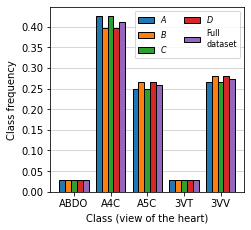

In [82]:
X_axis = np.arange(5)

gap = 0.2
width = (1-gap)/5

plt.figure(figsize=(3.5, 3.3))
plt.bar(X_axis-2*width, class_prob_A.values(), width, label='$A$',          color=colors[0], 
        edgecolor="black", zorder=1000)
plt.bar(X_axis-1*width, class_prob_B.values(), width, label='$B$',          color=colors[1], 
        edgecolor="black", zorder=1000)
plt.bar(X_axis+0*width, class_prob_C.values(), width, label='$C$',          color=colors[2], 
        edgecolor="black", zorder=1000)
plt.bar(X_axis+1*width, class_prob_D.values(), width, label='$D$',          color=colors[3], 
        edgecolor="black", zorder=1000)
plt.bar(X_axis+2*width, class_prob.values(),   width, label='Full\ndataset', color=colors[4], 
        edgecolor="black", zorder=1000)

plt.xticks(X_axis, keys)
plt.xlabel("Class (view of the heart)")
plt.ylabel('Class frequency')
plt.grid(lw=0.5, axis="y", zorder=-1000)
# plt.title("Class frequencies")
plt.legend(fontsize=8, ncols=2)
plt.tight_layout()
plt.savefig(outdir + "medical_imaging_fig7e.pdf")
plt.show()

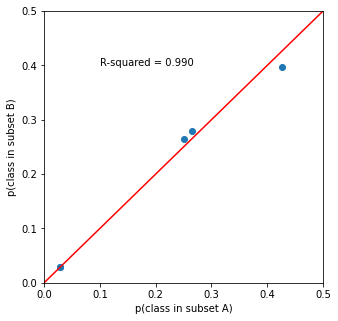

In [83]:
plt.figure(figsize=(5, 5))
plt.scatter(x=class_prob_A.values(), y=class_prob_B.values())
plt.annotate("R-squared = {:.3f}".format(r_squared_partition_1), (0.1, 0.4))
plt.plot([0,0.5],[0,0.5],color='red')
plt.xlim([0, 0.5])
plt.ylim([0, 0.5])
plt.xlabel("p(class in subset A)")
plt.ylabel("p(class in subset B)")
plt.show()

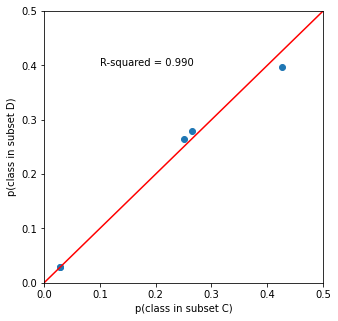

In [84]:
plt.figure(figsize=(5, 5))
plt.scatter(x= class_prob_C.values(), y= class_prob_D.values())
plt.annotate("R-squared = {:.3f}".format(r_squared_partition_2), (0.1, 0.4))
plt.plot([0,0.5],[0,0.5],color='red')
plt.xlim([0, 0.5])
plt.ylim([0, 0.5])
plt.xlabel("p(class in subset C)")
plt.ylabel("p(class in subset D)")
plt.show()

### Deriving upper bounds for rho and for rho-bar

Using the monotonicity of the power mean with respect to its subscript, i.e. $r \leq s$ implies
$$
M_{r}(u, x) \leq M_{s}(u, x)
$$
we get
$$
{}^{q}\rho^{Z}_{j} \leq M_{1} \left( \bar{P}_{\cdot j} ; \frac{Zp}{Z P_{\cdot j}} \right) = \sum_{i \in \mathrm{supp}{(\bar{P}_{\cdot j})}} (\bar{P}_{\cdot j})_{i} \frac{(Zp)_{i}}{w_{j} (Z \bar{P}_{\cdot j})_{i}}
$$
Next, if we assume that all the diagonal entries of $Z$ are 1, then we have
$$
(Z \bar{P}_{\cdot j})_{i} \geq (\bar{P}_{\cdot j})_{i}
$$
and we find the upper bound
$$
{}^{q} \rho^{Z}_{j} \leq \frac{ \sum_{i} (Zp)_{i} }{w_{j}}
$$
Similarly, we find the following upper bound for rho-bar:
$$
{}^{q} \bar{\rho}^{Z}_{j} \leq \sum_{i} (Z p)_{i}
$$

In [85]:
#Computing the upper bound for rho-bar
p = np.array([num[0] for num in metacommunity.abundance.metacommunity_abundance])

In [86]:
rho_bar_upper_bound = np.sum(np.dot(sim_array_rescaled, p))

In [87]:
rho_bar_upper_bound

28.84325306909394